In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
test_df = pd.read_csv('/content/test.csv')

In [3]:
column = 'label'

In [4]:
test_df[column].unique()

array([1, 0])

In [5]:
test_df.isnull().sum()

,0
sl_no,0
text,0
rating,0
label,0


Text Preprocessing

In [6]:
import nltk
import re
from tqdm import tqdm
import string
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import torch
import torch.nn as nn
import torch.optim as optim

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
STOPWORDS=set(stopwords.words('english'))

In [9]:
def remove_url_and_email(string):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')

    email_pattern = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b')

    string = url_pattern.sub(r'', string)
    string = email_pattern.sub(r'', string)

    return string

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'',text)


def text_preprocess(df):
  df['cleaned_text'] = df['text'].apply(lambda x: " ".join([word.lower() for word in x.split()])) # Lowercase removed
  df['cleaned_text'] = df['cleaned_text'].apply(lambda x: remove_url_and_email(x)) # URLs removed
  df['cleaned_text'] = df['cleaned_text'].apply(lambda x: remove_html(x)) # HTML tags removed
  df['cleaned_text'] = df['cleaned_text'].apply(lambda x: " ".join([word for word in x.split() if word not in STOPWORDS])) # stopwords removed
  df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x)) # punctuation removed
  df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'\d+', '', x)) # digits removed
  df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'\s+', ' ', x)) # extra whitespace
  df['cleaned_text'] = df['cleaned_text'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 2])) # short words removed
  df['cleaned_text'] = df['cleaned_text'].apply(lambda x: [word for word in x.split()]) # tokenized

  return df

In [10]:
new_test_df = text_preprocess(test_df)

TEXT VISULAIZATION

In [11]:
new_test_df['length'] = new_test_df['cleaned_text'].apply(lambda x: len(x))

In [12]:
new_test_df['length'].max()

1410

In [13]:
new_test_df['length'].min()

4

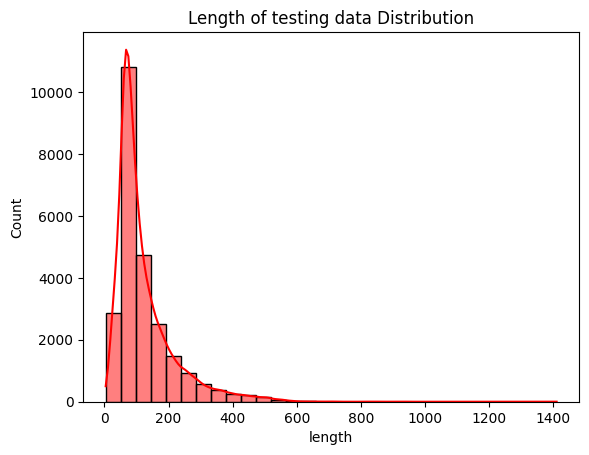

In [14]:
sns.histplot(new_test_df['length'],kde=True,color='red',bins=30)
plt.title('Length of testing data Distribution')
plt.show()

In [15]:
new_test_df.shape

(25000, 6)

VOCAB

In [16]:
vocab = Counter()
for text in new_test_df['cleaned_text']:
    vocab.update(text)

In [17]:
vocab_sorted = vocab.most_common()

In [18]:
vocab_sorted = ['<pad>'] + [word for word, _ in vocab_sorted]

In [19]:
vocab_sorted[:10]

['<pad>',
 'movie',
 'film',
 'one',
 'like',
 'good',
 'the',
 'time',
 'even',
 'would']

In [20]:
vocab_size = len(vocab_sorted)
print(vocab_size)

74025


In [21]:
word_to_index = {word: index for index, word in enumerate(vocab_sorted)}
index_to_word = {index: word for index, word in enumerate(vocab_sorted)}

PADDING AND TRUNCATION

In [22]:
def padding_truncate(text_list,max_sequence):

    if len(text_list) > max_sequence:
        # Truncate the list if it's longer than max_sequence
        return text_list[:max_sequence]
    else:
        # Pad the list with the padding_value if it's shorter than max_sequence
        return text_list + ['<pad>'] * (max_sequence - len(text_list))

In [23]:
new_test_df['cleaned_text'] = new_test_df['cleaned_text'].apply(lambda x: padding_truncate(x,400))

In [24]:
new_test_df['text_seq'] = new_test_df['cleaned_text'].apply(lambda x: [word_to_index[word] for word in x])

In [25]:
test_data = new_test_df[['text_seq', 'label']]

CREATE DATASET TENSOR

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [27]:
class SentimentDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text_seq = self.data.iloc[idx]['text_seq']
        label = self.data.iloc[idx]['label']
        return torch.tensor(text_seq), torch.tensor(label)

In [28]:
test_data_set = SentimentDataset(test_data)

In [29]:
test_dataloader = DataLoader(test_data_set, batch_size=32, shuffle=False)

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [31]:
class lstm_model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            batch_first=True,
        )
        self.dropout = nn.Dropout(dropout)  # Dropout layer
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def init_hidden(self, batch_size):
        factor = 2 if self.bidirectional else 1
        h0 = torch.zeros(self.n_layers * factor, batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(self.n_layers * factor, batch_size, self.hidden_dim).to(device)
        hidden = (h0, c0)
        return hidden

    def forward(self, x, hidden):
        batch_size = x.size(0)
        embedded = self.embedding(x)  # Embedding layer
        lstm_out, hidden = self.lstm(embedded, hidden)  # LSTM layer
        lstm_out = self.dropout(lstm_out)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim * 2 if self.bidirectional else self.hidden_dim)
        out = self.fc(lstm_out)
        sig_out = self.sigmoid(out)

        # Reshape for final output and select the output of last time-step
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]  # Getting the last prediction

        return sig_out, hidden

In [32]:
def acc(pred, label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [33]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(preds) # Round prediction

    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

UNIDIRECTIONAL LSTM

In [34]:
embedding_dim = 128
hidden_dim = 256
output_dim = 1
n_layers = 2
bidirectional = False
dropout = 0.5

model = lstm_model(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)

torch.save(model.state_dict(), "Model.pth")
print("Model saved successfully!")

model = model.to(device)
print(model)

Model saved successfully!
lstm_model(
  (embedding): Embedding(74025, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [35]:
model = lstm_model(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)

model.load_state_dict(torch.load('/content/Model.pth', map_location=device))

model = model.to(device)
print(model)


lstm_model(
  (embedding): Embedding(74025, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [36]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [37]:
model.eval()
test_loss = 0.0
test_acc = 0.0
with torch.no_grad():
    for text_seq, label in test_dataloader:
        text_seq, label = text_seq.to(device), label.to(device)
        hidden = model.init_hidden(text_seq.size(0))
        output, _ = model(text_seq, hidden)
        loss = criterion(output, label.float())
        test_loss += loss.item()
        test_acc += binary_accuracy(output, label)

test_loss /= len(test_dataloader)
test_acc /= len(test_dataloader)
print(f'Test loss is {test_loss}')
print(f'Test accuracy is {test_acc}')

Test loss is 0.6932103092713124
Test accuracy is 0.49624359607696533


In [38]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for text_seq, label in test_dataloader:
        text_seq, label = text_seq.to(device), label.to(device)
        hidden = model.init_hidden(text_seq.size(0))

        output, _ = model(text_seq, hidden)

        preds = (output > 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

cm = confusion_matrix(all_labels, all_preds)

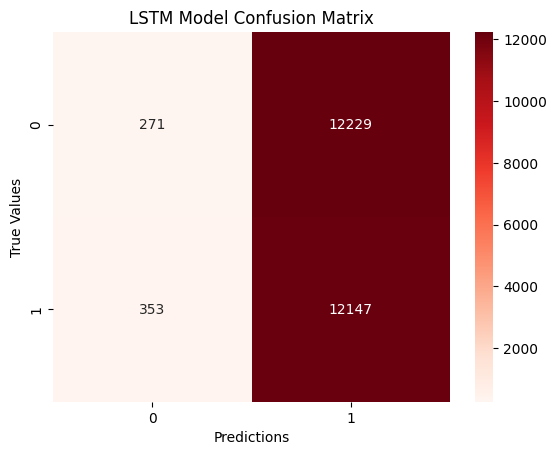

In [39]:
sns.heatmap(cm,fmt='d',cmap='Reds',annot=True)
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.title('LSTM Model Confusion Matrix')
plt.show()

In [40]:
UniLSTM_ClassificationReport = classification_report(all_labels,all_preds)
print('Classification Report of LSTM Model : \n', UniLSTM_ClassificationReport)

Classification Report of LSTM Model : 
               precision    recall  f1-score   support

           0       0.43      0.02      0.04     12500
           1       0.50      0.97      0.66     12500

    accuracy                           0.50     25000
   macro avg       0.47      0.50      0.35     25000
weighted avg       0.47      0.50      0.35     25000

